# Option-Implied Probability  
This script is inspired by https://reasonabledeviations.com/2020/10/01/option-implied-pdfs/

In [47]:
#import nasdaqdatalink
#raw_sb = nasdaqdatalink.get("ZL")

# Downloaded +/-50 from: https://www.barchart.com/futures/quotes/ZL*0/options?moneyness=20
import pandas as pd
raw_sbo = pd.read_csv('zlf23-options-american-options-exp-12_23_22-50-strikes-intraday-12-03-2022.csv')
commodity='Soybean Oil'
raw_sbo

,Strike,High,Low,Last,Change,Bid,Ask,Volume,Open Int,Premium,Last Trade
0,53.000C,12.295,12.295,12.295,-0.980,0.0,0.0,NaN,NaN,7377.0,12/02/22
1,53.000P,0.295,0.090,0.090,-0.115,0.0,0.0,1.0,159.0,54.0,12/02/22
2,53.500C,11.805,11.805,11.805,-0.990,0.0,0.0,NaN,NaN,7083.0,12/02/22
3,53.500P,0.105,0.105,0.105,-0.125,0.0,0.0,NaN,47.0,63.0,12/02/22
4,54.000C,11.320,11.320,11.320,-1.005,0.0,0.0,NaN,NaN,6792.0,12/02/22
...,...,...,...,...,...,...,...,...,...,...,...
96,77.000C,0.110,0.050,0.055,-0.060,0.0,0.0,146.0,682.0,33.0,12/02/22
97,77.000P,11.820,11.820,11.820,0.815,0.0,0.0,NaN,20.0,7092.0,12/02/22
98,77.500C,0.045,0.045,0.045,-0.050,0.0,0.0,NaN,583.0,27.0,12/02/22
99,77.500P,12.310,12.310,12.310,0.820,0.0,0.0,NaN,2.0,7386.0,12/02/22


In [48]:
# Assign Types, Normalize DF (Separate Columns)
def clean_options(df, reduce=False, size=30):
    # Fix Types
    import numpy as np
    df = df.replace(np.nan,0)
    df.Volume = df.Volume.astype(int)
    df['Open Int'] = df['Open Int'].astype(int)

    # Separate Columns
    df['Strike Price'] = df.Strike.str.extract('(\d+\.\d+)').astype(float)
    df['Type'] = df.Strike.str[-1]
    df.Type = df.Type.replace({'C': 'Call', 'P': 'Put'})
    df = df.drop(['Strike'], axis=1)

    # Fix Date
    df['Last Trade'] = df['Last Trade'].str.replace('CT', '', regex=True)
    df['Last Trade'] = pd.to_datetime(df['Last Trade']).dt.tz_localize('America/Chicago')

    # Drop last row
    df = df.dropna()

    # Filter to +/-30
    def reduce_scope(df, size=30):
        size=size/2
        mid_strike = df['Strike Price'].mean()
        l_range = mid_strike - size
        u_range = mid_strike + size
        df = df[df['Strike Price'].between(l_range, u_range)]
        return(df)
    if reduce:
        sbo = reduce_scope(df)

    return df[['Last Trade','Strike Price','Type','Last','Volume','Open Int','Premium']]

sbo = clean_options(raw_sbo)
sbo

,Last Trade,Strike Price,Type,Last,Volume,Open Int,Premium
0,2022-12-02 00:00:00-06:00,53.0,Call,12.295,0,0,7377.0
1,2022-12-02 00:00:00-06:00,53.0,Put,0.090,1,159,54.0
2,2022-12-02 00:00:00-06:00,53.5,Call,11.805,0,0,7083.0
3,2022-12-02 00:00:00-06:00,53.5,Put,0.105,0,47,63.0
4,2022-12-02 00:00:00-06:00,54.0,Call,11.320,0,0,6792.0
...,...,...,...,...,...,...,...
95,2022-12-02 00:00:00-06:00,76.5,Put,11.330,0,2,6798.0
96,2022-12-02 00:00:00-06:00,77.0,Call,0.055,146,682,33.0
97,2022-12-02 00:00:00-06:00,77.0,Put,11.820,0,20,7092.0
98,2022-12-02 00:00:00-06:00,77.5,Call,0.045,0,583,27.0


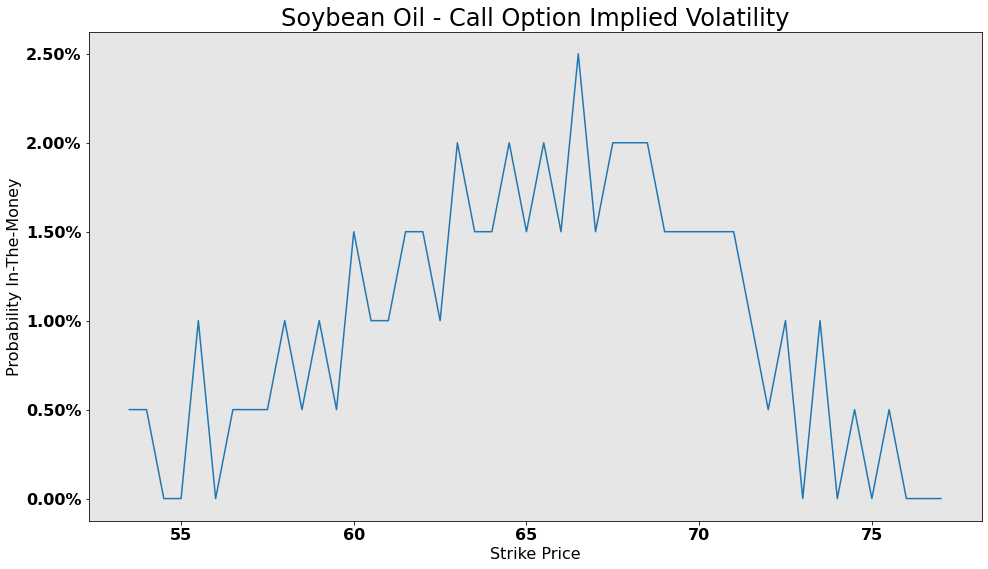

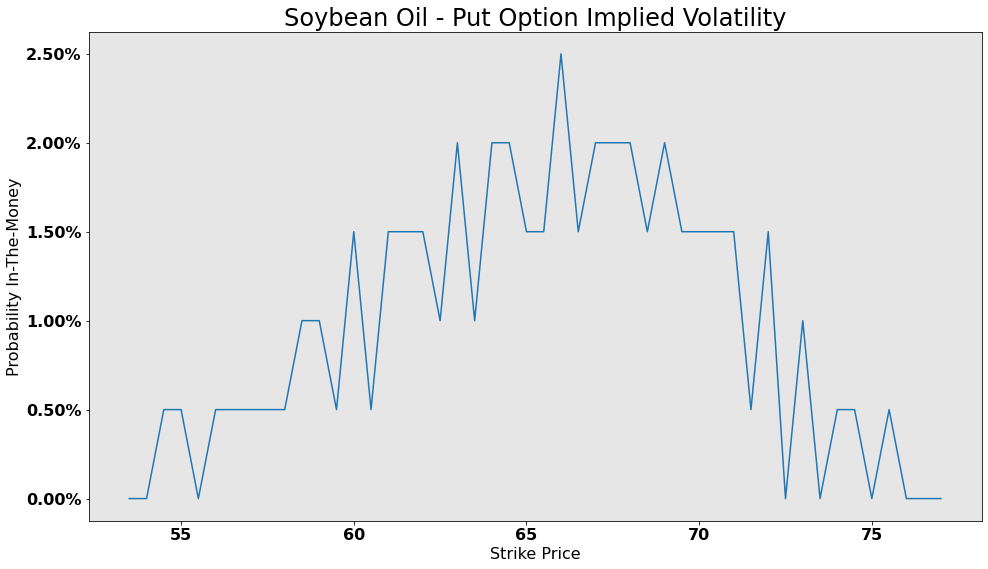

,Strike Price,Probability,Type
0,53.5,5.000000e-01,Call
1,54.0,5.000000e-01,Call
2,54.5,0.000000e+00,Call
3,55.0,1.776357e-13,Call
4,55.5,1.000000e+00,Call
...,...,...,...
91,75.0,0.000000e+00,Put
92,75.5,5.000000e-01,Put
93,76.0,0.000000e+00,Put
94,76.5,0.000000e+00,Put


In [53]:
# Calculate probabilities from strike and price, then visualize p
def get_probs(df, strikes_name, prices_name):

    def visualize_pdf(strikes, probs):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick
        plt.rcParams.update({'font.size': 16, 'font.weight': 'bold', 'figure.figsize': (16,9)})

        fig, ax = plt.subplots(figsize=(16,9))
        ax.plot(strikes, probs)
        ax.set_title(f'{commodity} - {t} Option Implied Volatility',fontsize = 24)
        ax.set_xlabel('Strike Price')
        ax.set_ylabel('Probability In-The-Money')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.set_facecolor('#E6E6E6')
        plt.show()

    # Calculate probabilities and visualize PDF for Call and Put options
    for t in df.Type.unique():
        dfo=df[df.Type == t]
        strikes=dfo[strikes_name]
        prices=dfo[prices_name]

        # Window the df to have one strike per row, but the 3 prices near it for each butterfly
        import numpy as np
        strike, l_price, m_price, u_price = [], [], [], []
        for i in np.arange(0,len(strikes)):
            if (i>0) & (i<len(strikes)-1):
                l_price.append(prices.iloc[i-1])
                strike.append(strikes.iloc[i])
                m_price.append(prices.iloc[i])
                u_price.append(prices.iloc[i+1])
    
        # For each strike price, calculate the probability, p
        s, p = [], []
        for i in np.arange(0,len(strike)):
            sp = strike[i]
            lp = l_price[i]
            mp = m_price[i]
            up = u_price[i]

            # Calculate the probability a future expires at the target price
            prob = lp - (2 * mp) + up
            s.append(sp)
            p.append(prob)
        p = [i * 100 for i in p]
        visualize_pdf(s,p)

        probs = pd.DataFrame({'Strike Price': s,'Probability':p})
        #probs.Probability = probs.Probability * 100
        probs=probs.dropna(axis=0)

        if t=='Call':
            c_probs = probs
        elif t=='Put':
            p_probs = probs
    # Merge data
    c_probs['Type']='Call'
    p_probs['Type']='Put'
    sbo_probs = pd.concat([c_probs,p_probs], ignore_index=True)
    return(sbo_probs)

# Filter Call Strikes and Prices
sbo_probs = get_probs(sbo, 'Strike Price', 'Last')
sbo_probs

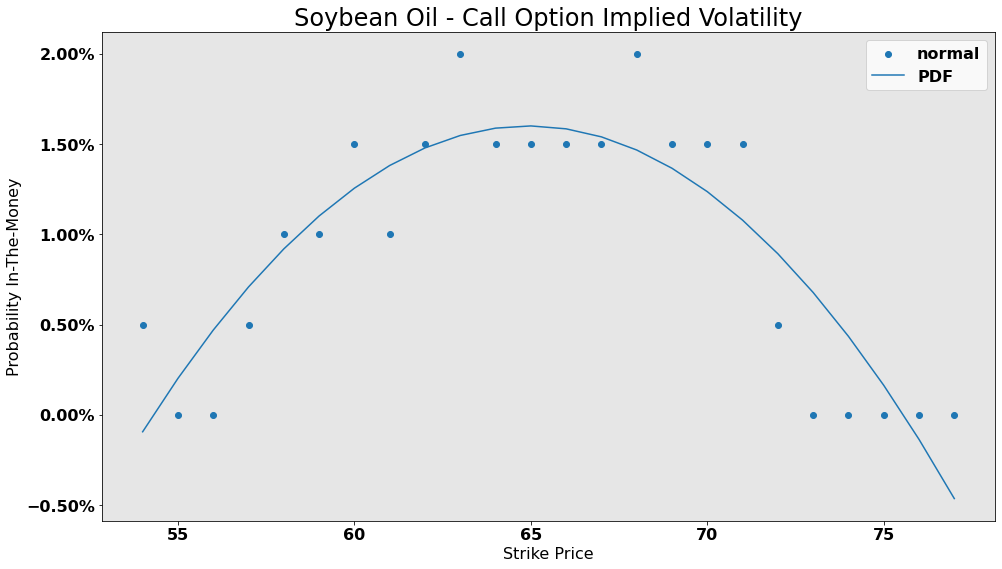

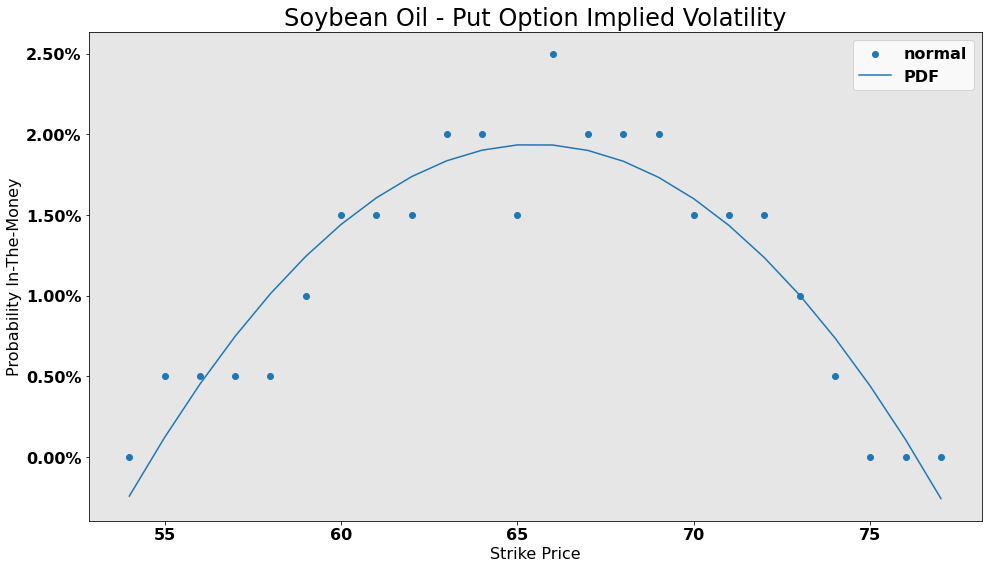

,Strike Price,Call Prob,Put Prob,Call PDF,Put PDF
0,54,0.5,0.0,-0.093846,-0.242500
1,55,0.0,0.5,0.201940,0.120978
2,56,0.0,0.5,0.469374,0.451354
3,57,0.5,0.5,0.708455,0.748626
4,58,1.0,0.5,0.919185,1.012796
5,59,1.0,1.0,1.101563,1.243864
6,60,1.5,1.5,1.255588,1.441828
7,61,1.0,1.5,1.381262,1.606690
8,62,1.5,1.5,1.478583,1.738449
9,63,2.0,2.0,1.547552,1.837105


In [54]:
# Calculate PDF from probs and visualize
def get_pdf(df, remove_outliers=True, derivatives=0):
    def visualize_pdf(strikes, probs, pdf):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick
        plt.rcParams.update({'font.size': 16, 'font.weight': 'bold', 'figure.figsize': (16,9)})

        fig, ax = plt.subplots(figsize=(16,9))
        ax.scatter(strikes, probs, marker='o', label='normal')
        ax.plot(x, pdf, label='PDF')
        ax.set_title(f'{commodity} - {t} Option Implied Volatility',fontsize = 24)
        ax.set_xlabel('Strike Price')
        ax.set_ylabel('Probability In-The-Money')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.set_facecolor('#E6E6E6')
        plt.legend()
        plt.show()
    
    # Remove Outliers
    if remove_outliers:
            import warnings
            warnings.filterwarnings("ignore")
            df = df[df['Strike Price'] == df['Strike Price'].astype(int)]
            df.iloc[:,0] = df.iloc[:,0].apply(pd.to_numeric)

    # Calcuate for Call and/or Put
    for t in df.Type.unique():
        dfo = df[df.Type == t]

        # Calculate Cubic Spline
        x = dfo['Strike Price']
        y = dfo['Probability']
        from sklearn.preprocessing import PolynomialFeatures
        polynomial_features= PolynomialFeatures(degree=2)
        import numpy as np
        xp = polynomial_features.fit_transform(np.array(x).reshape(-1,1))
        import statsmodels.api as sm
        model = sm.OLS(y, xp).fit()
        pdf = model.predict(xp)

        # Plot
        visualize_pdf(x, y, pdf)

        # Save
        if t=='Call':
            c_pdf = pd.Series(pdf)
            c_y = pd.Series(y)
            c_pdf.reset_index(drop=True, inplace=True)
            c_y.reset_index(drop=True, inplace=True)
        elif t=='Put':
            p_pdf = pd.Series(pdf)
            p_y = pd.Series(y)
            p_pdf.reset_index(drop=True, inplace=True)
            p_y.reset_index(drop=True, inplace=True)
    x = pd.Series(x)
    x.reset_index(inplace=True,drop=True)
    return(pd.DataFrame({'Strike Price':x.values.astype(int), 'Call Prob':c_y.values.round(decimals = 4), 'Put Prob':p_y.values, 'Call PDF':c_pdf.values, 'Put PDF':p_pdf.values}))

sbo_pdf = get_pdf(sbo_probs, True)
sbo_pdf

In [5]:
import datapane as dp
!datapane login --token=856743ad2e8cd913c6816ea39a222057b9da5d6e

Connected successfully to https://cloud.datapane.com as mac13faldet@gmail.com


In [56]:
# Melt dataframe for plotting in DataPane
df = sbo_pdf.copy()
df=pd.melt(df, id_vars=['Strike Price'], value_vars=['Call Prob','Put Prob','Call PDF','Put PDF'])
df.rename(columns={'variable':'Type','value':'Probability'}, inplace=True)
df.Probability = df.Probability.round(decimals = 2)
df



,Strike Price,Type,Probability
0,54,Call Prob,0.50
1,55,Call Prob,0.00
2,56,Call Prob,0.00
3,57,Call Prob,0.50
4,58,Call Prob,1.00
...,...,...,...
91,73,Put PDF,1.00
92,74,Put PDF,0.74
93,75,Put PDF,0.44
94,76,Put PDF,0.11


In [9]:
#import altair as alt
import datapane as dp

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 16, 'font.weight': 'bold', 'figure.figsize': (16,9)})

fig, ax = plt.subplots(figsize=(20,8))
ax.scatter(c_probs, color='red', marker='o', label='normal')
ax.scatter(p_probs, color='blue', marker='o', label='normal')
ax.plot(c_pdf, color='red', label='PDF')
ax.plot(p_pdf, color='blue' label='PDF')
ax.set_title(f'{commodity} - {t} Option Implied Volatility',fontsize = 24)
ax.set_xlabel('Strike Price')
ax.set_ylabel('Probability In-The-Money')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_facecolor('#E6E6E6')
plt.legend()

fig = df.plot.scatter(x='Strike Price', y='fertility')
dp.Report(dp.Plot(fig)).upload(name="test_mpl")


dp.Report(                                             # This initiates the report
    dp.Text(f"# {commodity} PDF"),             # Adding Text
    dp.Text("### Option Implied Probability"),
    dp.Text("""Probabilities calculated using option butterflys. Long two contracts of a Strike Price, short the strike +1 and -1."""),
    dp.Plot(fig_pdf),                      #Adding a Plot
    dp.Text(f"#### PDF of {commodity}"),
    dp.Group(
        dp.Plot(x,y),
        dp.Plot(x,c_pdf),
        dp.Plot(x, p_pdf),
        columns=3),
    dp.Group(
        dp.Plot(eda_fig_yz),
        dp.Plot(eda_fig_yt),
        dp.Plot(eda_fig_zt),
        columns=3),
    dp.Text(""" This is where I would talk about each variables collinearity
            found in the 6 figures above"""),
    
    dp.Group(                                          #Creating Columns
        dp.BigNumber(
            heading="Name of Metric",
            value="0.95"
        ),
        dp.Text(
            "Heading for Metric and description of metric"
        ),
        columns=2),
    dp.Group(
        dp.BigNumber(
            heading="Name of Metric",
            value="0.95"
        ),
        dp.Text(
            "Heading for Metric and description of metric"
        ),
        columns=2),
    dp.Group(
        dp.BigNumber(
            heading="Name of Metric",
            value="0.95"
        ),
        dp.Text(
            "Heading for Metric and description of metric"
        ),
        columns=2),
    dp.Text("### Statistical Figures"),

    dp.Plot(fig_eda_mainfinding),                      #Adding a Plot
    dp.Text("#### Collinearity Between Variables"),
    dp.Group(
        dp.Plot(eda_fig_xy),
        dp.Plot(eda_fig_xz),
        dp.Plot(eda_fig_xt),
        columns=3),
    dp.Group(
        dp.Plot(eda_fig_yz),
        dp.Plot(eda_fig_yt),
        dp.Plot(eda_fig_zt),
        columns=3),
    dp.Text(""" This is where I would talk about each variables collinearity
            found in the 6 figures above"""),
).upload(name="My first Datapane Report!") 



app.upload(name=f"{commodity} Options Implied PDF", open=True)

app.save("SBO_PDF.html")

c:\Users\macfa\anaconda3\envs\Dev\lib\site-packages\datapane\common\df_processor.py:28: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(df.index, pd.Int64Index):


TypeError: from_notebook() takes from 0 to 1 positional arguments but 3 were given

In [6]:
import altair as alt
from vega_datasets import data

import datapane as dp

df = data.cars()

plot1 = alt.Chart(df).mark_circle(size=60).encode(
    x='Horsepower', y='Miles_per_Gallon', color='Origin',
    tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).interactive()

#app = dp.App.from_notebook()
app = dp.App(
    dp.Plot(plot1),
    dp.DataTable(df)
)
app.upload(name=f"{commodity} Options Implied PDF", open=True)

Uploading app and associated data - *please wait...*

App successfully uploaded. View and share your app at <a href='https://cloud.datapane.com/apps/qkWezB3/my-example-report/' target='_blank'>here</a>.